# 1. Data Collection

In [ ]:
from bs4 import BeautifulSoup
import requests
import re


def get_soup(url):

    headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:57.0) Gecko/20100101 Firefox/57.0'}

    r = s.get(url, headers=headers)

    #with open('temp.html', 'wb') as f:
    #    f.write(r.content)
    #    webbrowser.open('temp.html')

    if r.status_code != 200:
        print('status code:', r.status_code)
    else:
        return BeautifulSoup(r.text, 'html.parser')

def parse(url, response):

    if not response:
        print('no response:', url)
        return

    # get number of reviews
    num_reviews = response.find('span', class_='reviews_header_count').text
    num_reviews = num_reviews[1:-1] # remove `( )`
    num_reviews = num_reviews.replace(',', '') # remove `,`
    num_reviews = int(num_reviews)
    print('num_reviews:', num_reviews, type(num_reviews))

    # create template for urls to pages with reviews
    url = url.replace('.html', '-or{}.html')
    print('template:', url)

    # load pages with reviews
    for offset in range(0, num_reviews, 5):
        print('url:', url.format(offset))
        url_ = url.format(offset)
        parse_reviews(url_, get_soup(url_))
        return # for test only - to stop after first page

def parse_reviews(url, response):
    print('review:', url)

    if not response:
        print('no response:', url)
        return

    # get every review
    for idx, review in enumerate(response.find_all('div', class_='review-container')):
        item = {
            'restaurant_name': response.find('h1', class_='ui_header').text,
            'review_title': review.find('span', class_='noQuotes').text,
            'review_body': review.find('p', class_='partial_entry').text,
            'review_date': review.find('span', class_='ratingDate')['title'],#.text,#[idx],
            'num_reviews_reviewer': review.find('span', class_='badgeText').text,
            'reviewer_name': review.find('div', class_='info_text').text,
            'bubble_rating': review.select_one(' span.ui_bubble_rating')['class'][1][7:],
        }

        results.append(item) # <--- add to global list

        #~ yield item
        for key,val in item.items():
            print(key, ':', val)
        print('----')
        #return # for test only - to stop after first review


# --- main ---

s = requests.Session()

start_urls = [
    'https://www.tripadvisor.fr/Restaurant_Review-g661266-d8297622-Reviews-McDonald_s-Yutz_Moselle_Grand_Est.html',
    'https://www.tripadvisor.fr/Restaurant_Review-g661266-d8297622-Reviews-or10-McDonald_s-Yutz_Moselle_Grand_Est.html',
    'https://www.tripadvisor.fr/Restaurant_Review-g661266-d8297622-Reviews-or20-McDonald_s-Yutz_Moselle_Grand_Est.html',
    'https://www.tripadvisor.fr/Restaurant_Review-g661266-d8297622-Reviews-or30-McDonald_s-Yutz_Moselle_Grand_Est.html',
    'https://www.tripadvisor.fr/Restaurant_Review-g661266-d8297622-Reviews-or40-McDonald_s-Yutz_Moselle_Grand_Est.html',
    'https://www.tripadvisor.fr/Restaurant_Review-g661266-d8297622-Reviews-or50-McDonald_s-Yutz_Moselle_Grand_Est.html',
    'https://www.tripadvisor.fr/Restaurant_Review-g661266-d8297622-Reviews-or60-McDonald_s-Yutz_Moselle_Grand_Est.html',
    'https://www.tripadvisor.fr/Restaurant_Review-g661266-d8297622-Reviews-or70-McDonald_s-Yutz_Moselle_Grand_Est.html',
    'https://www.tripadvisor.fr/Restaurant_Review-g661266-d8297622-Reviews-or80-McDonald_s-Yutz_Moselle_Grand_Est.html',
    'https://www.tripadvisor.fr/Restaurant_Review-g661266-d8297622-Reviews-or90-McDonald_s-Yutz_Moselle_Grand_Est.html',
    'https://www.tripadvisor.fr/Restaurant_Review-g661266-d8297622-Reviews-or100-McDonald_s-Yutz_Moselle_Grand_Est.html',
    'https://www.tripadvisor.fr/Restaurant_Review-g661266-d8297622-Reviews-or110-McDonald_s-Yutz_Moselle_Grand_Est.html',
    'https://www.tripadvisor.fr/Restaurant_Review-g661266-d8297622-Reviews-or120-McDonald_s-Yutz_Moselle_Grand_Est.html',
    'https://www.tripadvisor.fr/Restaurant_Review-g187147-d4358263-Reviews-Macdonald_s_Max_Dormoy-Paris_Ile_de_France.html',
    'https://www.tripadvisor.fr/Restaurant_Review-g187147-d4358263-Reviews-or10-Macdonald_s_Max_Dormoy-Paris_Ile_de_France.html'
]

In [ ]:
results = [] # <--- global list for items

for url in start_urls:
    parse(url, get_soup(url))

import pandas as pd
df = pd.DataFrame(results) # <--- convert list to DataFrame
df["bubble_rating"] = pd.to_numeric(df["bubble_rating"])
df['bubble_rating']=df['bubble_rating']/10

df.to_csv('dataTripAdvisor.csv')    # <--- save in file

# 2. Data preparation

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('dataTripAdvisor.csv')

In [ ]:
df.head()

,Unnamed: 0,restaurant_name,review_title,review_body,review_date,num_reviews_reviewer,reviewer_name,bubble_rating
0,0,McDonald's,Honteux,Personnels qui fume leurs clopes devant la por...,10 avril 2020,1 avis,pascala142,1.0
1,1,McDonald's,Désastreux !!!!!!,Hygiène exécrable!!!!\nPersonnel d’une lenteur...,7 mars 2020,1 avis,ivanew2020,1.0
2,2,McDonald's,Désastreux...uniquement si vous mourrez de fai...,Arrive a 14h00 aujourd’hui au drive. Personne ...,19 février 2020,19 avis,LeSchrek,1.0
3,3,McDonald's,Macdo yutz,Je suis venu manger macdo à yutz avec mon neve...,16 février 2020,1 avis,chloebW3848IQ,1.0
4,4,McDonald's,le plus horrible des Mac Do,"Je suis passé avec mon epouse samedi,c'etait é...",4 février 2020,1 avis,popinol,1.0


In [ ]:
df=df.drop('Unnamed: 0', axis=1)

In [ ]:
df.shape

(139, 7)

## 2.1 Tokenization

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize 
sentences = df['review_body'].apply(sent_tokenize)
words = df['review_body'].apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## 2.2 Remove indesired ponctuation 

In [ ]:
import string
def remove_punctuation(text):
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

In [ ]:
df['review_body']=df['review_body'].apply(remove_punctuation)

## 2.3 Remove stopwords

In [ ]:
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words('french')
corpus=[]
def stopwords(text):

    
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    text = [word.lower() for word in text.split() if word.lower() not in sw]
   
    j=" ".join(text)
    corpus.append(j)
    return j

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df['review_body']=df['review_body'].apply(stopwords)

In [ ]:
df['review_body'][3]

'venu manger macdo yutz neveu macdo tais infecte sandwichs sauce tais tout froid poteries frite dur comme b personnel parlons dirait rienplus'

## 2.4 Lemmetization and Stemming

In [ ]:
import gensim
import nltk
nltk.download('wordnet')
from nltk.stem import SnowballStemmer,WordNetLemmatizer
def lemmatize_stemming(text):
    stemmer=SnowballStemmer('french')
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# 3. Transformation saved

In [ ]:
processed_docs = df['review_body'].map(preprocess)
processed_docs[:10]

0    [personnel, fum, leur, clop, dev, port, dentr,...
1    [hyg, crabl, personnel, lenteur, inimagin, per...
2    [arriv, aujourd, driv, person, dev, plut, calm...
3    [venu, mang, macdo, yutz, neveu, macdo, tais, ...
4    [pass, epous, samedicet, tabl, nettoy, fait, b...
5    [arriv, voitur, dev, pris, command, temp, gler...
6    [bonsoir, met, souvent, avis, dern, rienc, fas...
7    [sandwich, froid, touff, cheveux, potato, hont...
8    [pir, restaur, con, toujour, minimum, dattent,...
9    [pir, pir, dimanch, soir, minut, attent, driv,...
Name: review_body, dtype: object

# 4. Bag of words

In [ ]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

        

0 able
1 cest
2 client
3 clop
4 dentr
5 dev
6 fuir
7 fum
8 gueul
9 honteux
10 hyg


In [ ]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# 5. Doc2bow

In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
print(bow_corpus[5])
print(bow_corpus[14])

# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(processed_docs)
# convert tokenized documents into a document-term matrix
bow_corpus = [dictionary.doc2bow(text) for text in processed_docs]

[(0, 1), (4, 2), (7, 1)]
[(2, 1), (6, 1), (10, 1), (12, 2)]


In [ ]:
list(dictionary.values());

In [ ]:
bow_doc_14 = bow_corpus[14]
for i in range(len(bow_doc_14)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_14[i][0], 
                                               dictionary[bow_doc_14[i][0]], 
bow_doc_14[i][1]))

Word 2 ("personnel") appears 1 time.
Word 6 ("attent") appears 1 time.
Word 10 ("mang") appears 1 time.
Word 12 ("tout") appears 2 time.


# 6. TF-ID

In [ ]:

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.4822917247005284),
 (1, 0.6405393825799295),
 (2, 0.42255413360273286),
 (3, 0.42255413360273286)]


# 7. LDA

In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary,chunksize=100,iterations=25, passes=2, workers=4)

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.171*"mang" + 0.148*"froid" + 0.129*"tout" + 0.122*"personnel" + 0.099*"frit" + 0.063*"restaur" + 0.059*"command" + 0.050*"sandwich" + 0.050*"serv" + 0.032*"cest"
Topic: 1 
Words: 0.302*"command" + 0.134*"driv" + 0.088*"fois" + 0.078*"personnel" + 0.055*"restaur" + 0.046*"mang" + 0.046*"tout" + 0.034*"attent" + 0.034*"cest" + 0.029*"manqu"
Topic: 2 
Words: 0.144*"command" + 0.114*"pass" + 0.110*"frit" + 0.100*"driv" + 0.093*"attent" + 0.083*"restaur" + 0.076*"personnel" + 0.038*"cest" + 0.035*"manqu" + 0.034*"toujour"
Topic: 3 
Words: 0.209*"tout" + 0.128*"cest" + 0.099*"command" + 0.097*"froid" + 0.079*"mang" + 0.076*"sandwich" + 0.075*"plus" + 0.045*"frit" + 0.034*"personnel" + 0.029*"pass"
Topic: 4 
Words: 0.134*"toujour" + 0.115*"pir" + 0.099*"pass" + 0.075*"cest" + 0.075*"tabl" + 0.072*"sal" + 0.072*"serv" + 0.063*"command" + 0.057*"sandwich" + 0.044*"tout"
Topic: 5 
Words: 0.309*"froid" + 0.085*"command" + 0.082*"sandwich" + 0.078*"toujour" + 0.062*"fois" + 0.05

# 8. LDA + TF_ID

In [ ]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary,chunksize=100,iterations=25, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.265*"froid" + 0.186*"mang" + 0.134*"sandwich" + 0.078*"toujour" + 0.070*"cest" + 0.068*"restaur" + 0.029*"command" + 0.026*"client" + 0.024*"attent" + 0.022*"manqu"
Topic: 1 Word: 0.207*"toujour" + 0.128*"manqu" + 0.101*"driv" + 0.094*"cest" + 0.084*"command" + 0.081*"sandwich" + 0.062*"plus" + 0.045*"pir" + 0.044*"restaur" + 0.036*"personnel"
Topic: 2 Word: 0.173*"tout" + 0.150*"froid" + 0.095*"sandwich" + 0.095*"serv" + 0.093*"command" + 0.059*"mang" + 0.049*"personnel" + 0.041*"sal" + 0.040*"attent" + 0.036*"frit"
Topic: 3 Word: 0.134*"cest" + 0.122*"pir" + 0.111*"pass" + 0.084*"tout" + 0.081*"restaur" + 0.069*"plus" + 0.064*"tabl" + 0.062*"mang" + 0.061*"toujour" + 0.055*"driv"
Topic: 4 Word: 0.140*"froid" + 0.093*"restaur" + 0.078*"sal" + 0.073*"frit" + 0.071*"serv" + 0.068*"pir" + 0.060*"manqu" + 0.059*"sandwich" + 0.053*"mang" + 0.053*"fois"
Topic: 5 Word: 0.242*"frit" + 0.166*"fois" + 0.106*"driv" + 0.094*"manqu" + 0.087*"plus" + 0.073*"command" + 0.049*"attent

# 9. Evaluation

## Evaluation using LDA Bag of Words model

In [ ]:
for index, score in sorted(lda_model[bow_corpus[14]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.6330733299255371	 
Topic: 0.171*"mang" + 0.148*"froid" + 0.129*"tout" + 0.122*"personnel" + 0.099*"frit" + 0.063*"restaur" + 0.059*"command" + 0.050*"sandwich" + 0.050*"serv" + 0.032*"cest"

Score: 0.2335716336965561	 
Topic: 0.171*"sal" + 0.128*"tabl" + 0.115*"attent" + 0.102*"personnel" + 0.071*"plus" + 0.065*"serv" + 0.061*"froid" + 0.058*"sandwich" + 0.051*"manqu" + 0.047*"command"

Score: 0.016672134399414062	 
Topic: 0.144*"command" + 0.114*"pass" + 0.110*"frit" + 0.100*"driv" + 0.093*"attent" + 0.083*"restaur" + 0.076*"personnel" + 0.038*"cest" + 0.035*"manqu" + 0.034*"toujour"

Score: 0.016672035679221153	 
Topic: 0.209*"tout" + 0.128*"cest" + 0.099*"command" + 0.097*"froid" + 0.079*"mang" + 0.076*"sandwich" + 0.075*"plus" + 0.045*"frit" + 0.034*"personnel" + 0.029*"pass"

Score: 0.01666986756026745	 
Topic: 0.302*"command" + 0.134*"driv" + 0.088*"fois" + 0.078*"personnel" + 0.055*"restaur" + 0.046*"mang" + 0.046*"tout" + 0.034*"attent" + 0.034*"cest" + 0.029*"manqu"


## Evaluation using LDA TF-IDF model

In [ ]:
for index, score in sorted(lda_model_tfidf[bow_corpus[14]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))



Score: 0.8499695658683777	 
Topic: 0.173*"tout" + 0.150*"froid" + 0.095*"sandwich" + 0.095*"serv" + 0.093*"command" + 0.059*"mang" + 0.049*"personnel" + 0.041*"sal" + 0.040*"attent" + 0.036*"frit"

Score: 0.0166741032153368	 
Topic: 0.158*"plus" + 0.154*"attent" + 0.128*"restaur" + 0.102*"command" + 0.065*"serv" + 0.057*"personnel" + 0.051*"pass" + 0.051*"manqu" + 0.034*"mang" + 0.032*"tout"

Score: 0.01667359285056591	 
Topic: 0.243*"personnel" + 0.140*"command" + 0.097*"pass" + 0.079*"pir" + 0.077*"driv" + 0.064*"sal" + 0.055*"fois" + 0.047*"toujour" + 0.027*"cest" + 0.024*"mang"

Score: 0.016670508310198784	 
Topic: 0.265*"froid" + 0.186*"mang" + 0.134*"sandwich" + 0.078*"toujour" + 0.070*"cest" + 0.068*"restaur" + 0.029*"command" + 0.026*"client" + 0.024*"attent" + 0.022*"manqu"

Score: 0.01667034812271595	 
Topic: 0.166*"cest" + 0.148*"sal" + 0.102*"client" + 0.090*"personnel" + 0.079*"tabl" + 0.074*"command" + 0.065*"pass" + 0.056*"plus" + 0.054*"restaur" + 0.043*"attent"

Score

In [ ]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.21666423868157847


#  10.Test

In [ ]:
unseen_document = "j'aime tout au macdo , fast food, endroit et atmosphère sont magnifiques "
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.5499685406684875	 Topic: 0.209*"tout" + 0.128*"cest" + 0.099*"command" + 0.097*"froid" + 0.079*"mang"
Score: 0.05001497641205788	 Topic: 0.171*"mang" + 0.148*"froid" + 0.129*"tout" + 0.122*"personnel" + 0.099*"frit"
Score: 0.05000494793057442	 Topic: 0.309*"froid" + 0.085*"command" + 0.082*"sandwich" + 0.078*"toujour" + 0.062*"fois"
Score: 0.05000436678528786	 Topic: 0.302*"command" + 0.134*"driv" + 0.088*"fois" + 0.078*"personnel" + 0.055*"restaur"
Score: 0.050003375858068466	 Topic: 0.134*"toujour" + 0.115*"pir" + 0.099*"pass" + 0.075*"cest" + 0.075*"tabl"
Score: 0.050002824515104294	 Topic: 0.171*"sal" + 0.128*"tabl" + 0.115*"attent" + 0.102*"personnel" + 0.071*"plus"
Score: 0.05000067874789238	 Topic: 0.144*"command" + 0.114*"pass" + 0.110*"frit" + 0.100*"driv" + 0.093*"attent"
Score: 0.050000227987766266	 Topic: 0.146*"plus" + 0.119*"fois" + 0.112*"driv" + 0.110*"pir" + 0.101*"frit"
Score: 0.05000005289912224	 Topic: 0.170*"command" + 0.136*"manqu" + 0.085*"toujour" + 0.0

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.21666423868157847


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


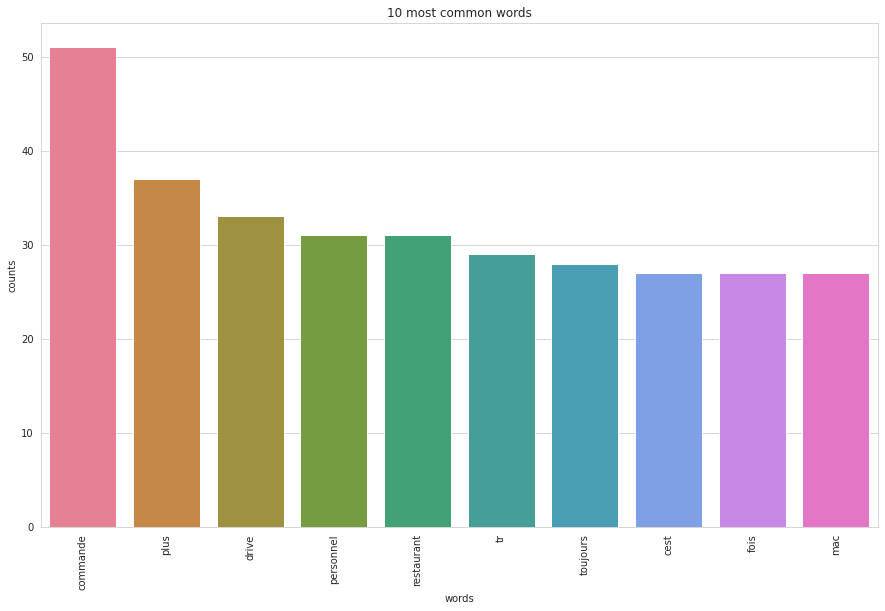

In [ ]:
 #Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words=['french'])
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['review_body'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

A propos de Mac'DO, on constate que les internautes sur TripAdvisor parlent souvent de leurs commandes établis, ils critiques aussi le personnel et le restaurant en général .